# Ontologe 스테이킹 리스크 헷지 전략

* Ontology 스테이킹을 헷지를 통해 최대한 안전수익률을 확보하는 전략
* 헷지 후 원화환산 예상 수익률은 약 25%

# Ontology Node Staking 문서 주요 정보

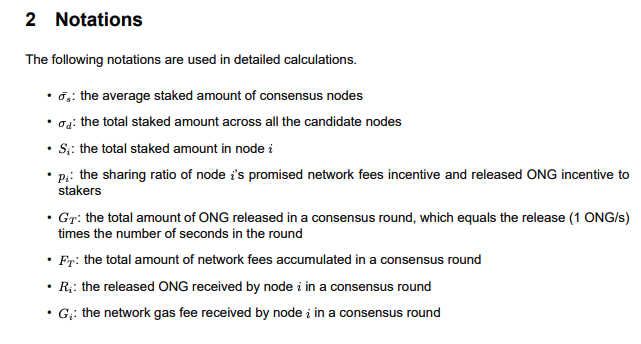

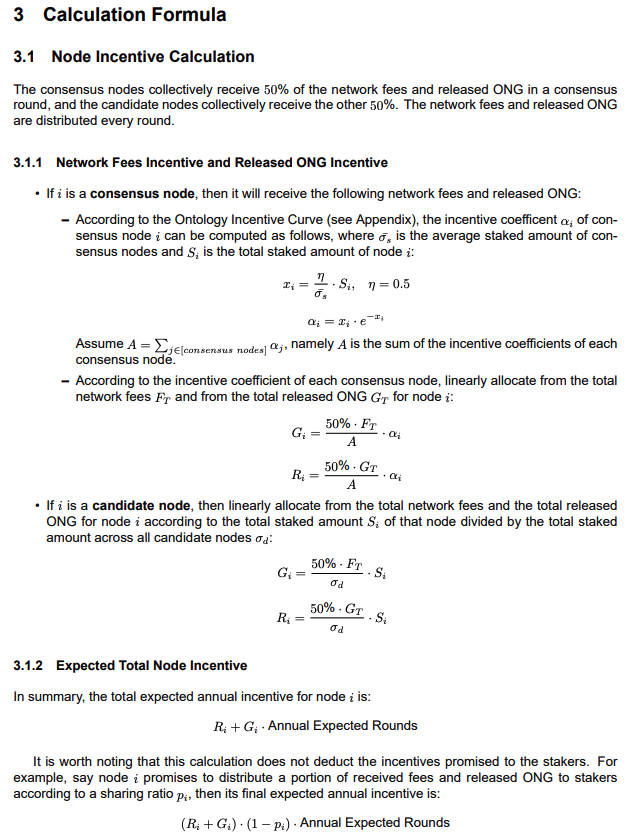

# 1. 예상 스테이킹 수익률
-------------

In [1]:
from crypro import pybinance, CONFIG
from datetime import datetime
import pandas as pd

biance = pybinance.Binance(CONFIG.BINANCE['API_KEY'], CONFIG.BINANCE['SECRET_KEY'],CONFIG.BINANCE['MAIN_URL'])

In [24]:
symbol = 'ONTUSDT'
interval = '4h'
start_str = '1 Jan 2018'
now = datetime.now()
end_str = now.strftime('%d %b %Y')

df_ont = biance.get_historical_spot_price('ONTUSDT', interval, start_str, end_str)
df_ong = biance.get_historical_spot_price('ONGUSDT', interval, start_str, end_str)

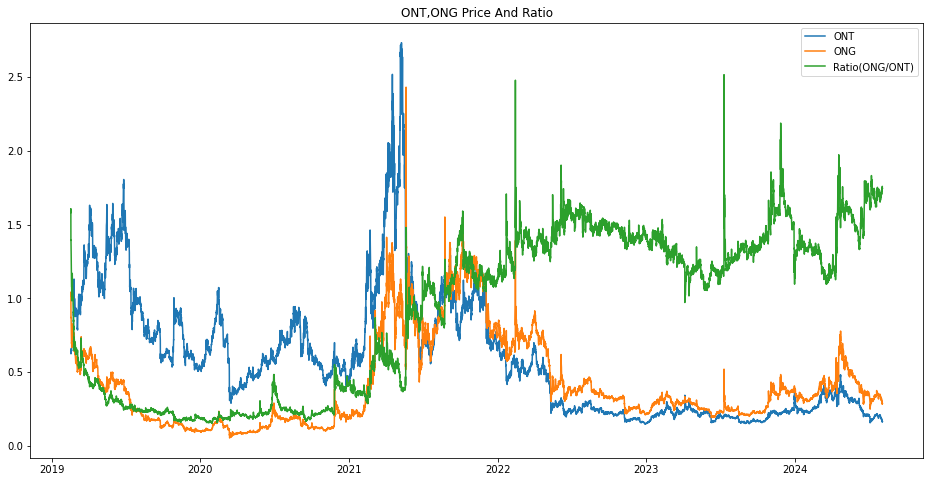

In [27]:
merged_df = pd.merge(df_ont, df_ong, on='timestamp')

merged_df['ratio'] = merged_df['close_y'] / merged_df['close_x']

merged_df = merged_df.dropna()

merged_df.set_index('timestamp', inplace=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.plot(merged_df['close_x'], label='ONT')
plt.plot(merged_df['close_y'], label='ONG')
plt.plot(merged_df['ratio'], label='Ratio(ONG/ONT)')
plt.legend()
plt.title('ONT,ONG Price And Ratio')
plt.show()

In [28]:
cons_node = 140461937
cand_node = 88066415
total_staking = cons_node + cand_node
print('Total Staking amount: ' ,format(total_staking,',d'))

Total Staking amount:  228,528,352


In [29]:
#1년동안 제공되는 총 ONG
GT = 60 * 60 * 24 * 365
cons_node_ret = GT / cons_node / 2 * merged_df['ratio'][-1]
print('Consensus Node staking return(expected): ' ,format(cons_node_ret,'%'))

cand_node_ret = GT / cand_node / 2 * merged_df['ratio'][-1]
print('Candidate Node staking return(expected): ' ,format(cand_node_ret,'%'))

Consensus Node staking return(expected):  19.592420%
Candidate Node staking return(expected):  31.249022%


# 2. 리스크
-------------
ONT 스테이킹을 하게되면 아래와 같은 리스크들이 존재하게 된다.
## Risk factors
(1) ONT price(Staking Amount) \
(2) ONG price(Reward Amount) \
(3) 환율(USDKRW) \
(4) 김치프리미엄 \
(5) 청산 리스크(가장 중요)

여기서는 중요도가 높다고 생각하는 (1), (3), (5) 에 대해서만 정리

## 2.1 ONT Price Risk

-------

가격변동을 헷지하는 수단으로 스테이킹과 동일한 포지션만큼 ONT Futures Short 포지션을 만든다.\
그러면 포지션은 ONT Spot Long + ONT Futures Short이 되고 ONT 가격변동 리스크는 사라지게 된다. \
위 헷지포지션을 구축하게 되면 현선물 basis가 열리게 된다. 선물은 만기가 없는 Perpetual Futures를 이용할 수 있고 현물 vs 선물 가격차이를 반영하는 Funding fee를 분석해보자.

### 2.1.1 ONT Futures 를 이용할 시 펀딩 피 손익 분석

In [4]:
from crypro import pybingx
bingx = pybingx.BingX(CONFIG.BINGX['API_KEY'], CONFIG.BINGX['API_KEY'],CONFIG.BINGX['MAIN_URL'])
df_ont = bingx.get_funding_rate_history('ONT')

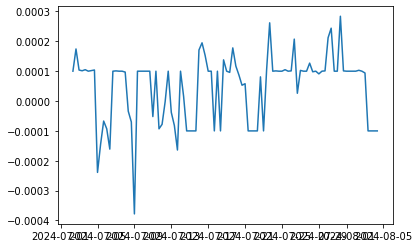

In [7]:
import matplotlib.pyplot as plt
plt.plot(df_ont.fundingTime, df_ont.fundingRate) 

## 2.3 환율(USDKRW) Risk

ONT Spot Long + ONT Futures Short 포지션을 가지고 있는 원화 투자자 입장에서는 원/달러 환율변동에 따라 손익이 바뀌게 된다. \
즉, ONT 가격이 계속 0.2불 이더라도 환율변동에 따라 ONT 원화 가격은 바뀌는것 처럼 말이다. \
그러면 ONT Spot Long + ONT Futures Short 포지션을 만들었을때 열리는 원/달러 환포지션의 크기는 어떻게 될까. \
환율이 바뀌었을 때 손익이 어떻게 바뀌는지 생각하면, 환포지션 = 스테이킹 ONT액수 + 증거금 이다. \
ex) 10,000 달러만큼 ONT를 매수하고 2배 레버리지로 10,000 만큼 숏포지션(증거금 5,000)을 구축하면 환포지션은 10,000+5,000=15,000 이다.

### 2.3.1 환율 리스크 헷지 방법

환율리스크는 장내파생상품에 상장되어있는 달러선물로 가능하다. 달러선물에 내재되어있는 헷지비용을 1년 비용으로 환산하면 대략 -2.1% 정도 된다.(헷지비용은 원화금리, 미국금리, 달러의 수요의 균형에서 결정.) \
미 금리 하락시 헷지 비용 감소할 가능성은 높아질 것이다. 하지만 경기가 침체되고 리스크 회피 성향이 강한 시장으로 간다면 달러의 수요로 인해 헷지 코스트가 증가할 가능성도 고려해야 될 것이다.

## 2.5 청산 Risk

--------

ONT의 가격을 헷지하기 위해 ONT Perpetial Futures Short 포지션을 가져가게 된다. 이때 발생하는 리스크는 ONT 가격이 급등하여 Futures Short 포지션이 청산당하는 경우이다. 충분한 증거금이 있으면 걱정할 필요는 없지만, 증거금을 충분하게 만들게 되면 그만큼 운용할 수 있는 자금이 부족하게 되어 수익률이 낮아지게 된다. ONT 스테이킹은 Consensus Round 가 진행되는 동안 출금을 할 수 없다. 즉 한 Round가 끝날 때 까지 청산리스크는 존재하게 된다.
한 Round는 최대 약 21일이다.

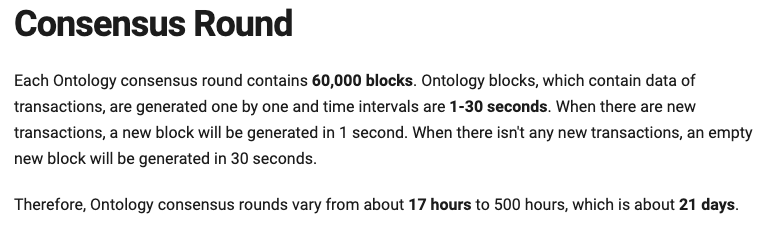

### 2.5.1 청산 리스크 과거 백테스트

1 Round는 최대 21일동안 유지될 수 있다. 이 기간동안 ONT가격이 오르면 청산 위험이 커지게 된다. 만약 1 Round 동안 ONT가격이 크게 상승하여 증거금이 부족해지게되면 ONT Futures 매도포지션이 청산당하여 헷지 포지션 유지가 어려워 진다. \
따라서 전체 투자금액에서 스테이킹 금액과 헷지증거금 비율을 적절하게 선택해야 한다. 예를들어 스테이킹 금액이 90, 헷지증거금비율이 10 이라면 수익률을 높게 가져갈 수 있지만 그만큼 청산위험이 커지게 되고, 스테이킹 금액이 50, 헷지증거금비율이 50 이라면 수익률은 상대적으로 낮겠지만 그만큼 청산 위험이 감소하게 된다.

아래는 ONT 가격이 21동안 최대한 올랐을 때 Max 수익률을 1시간 마다 측정한 그래프이다. y축은 과거 해당 시점에서 ONT를 투자했을때 21일 동안의 최대 수익률 나타낸다. 즉 y값의 높이가 높을수록 청산을 당했을 확률이 높아졌을 것이다.

In [30]:
df_ont = biance.get_historical_spot_price('ONTUSDT', '1h', start_str, end_str)

In [31]:
df_ont

,timestamp,open,high,low,close,volume
0,2018-06-08 07:00:00,8.3350,8.6420,8.2600,8.2900,39778.821
1,2018-06-08 08:00:00,8.3310,8.3310,8.2020,8.2930,16771.150
2,2018-06-08 09:00:00,8.2930,8.3200,8.1700,8.2050,9852.544
3,2018-06-08 10:00:00,8.2050,8.3290,8.0200,8.0510,25611.378
4,2018-06-08 11:00:00,8.0390,8.2920,8.0100,8.1610,49478.311
...,...,...,...,...,...,...
53884,2024-08-04 03:00:00,0.1656,0.1664,0.1651,0.1657,99565.000
53885,2024-08-04 04:00:00,0.1658,0.1666,0.1652,0.1652,85057.000
53886,2024-08-04 05:00:00,0.1652,0.1665,0.1649,0.1663,81341.000
53887,2024-08-04 06:00:00,0.1663,0.1673,0.1661,0.1670,119426.000


In [32]:
df_max_return = pd.DataFrame([])
round_days = 21
round_period = 24 * round_days

for i, row in df_ont.iterrows():
    start_price = row.open
    max_price = df_ont.iloc[i:i + round_period].high.max()
    df_max_return.loc[row.timestamp,'max_return'] = (max_price - start_price) / start_price

Text(0.5, 1.0, 'Rolling Max Return(21 days)')

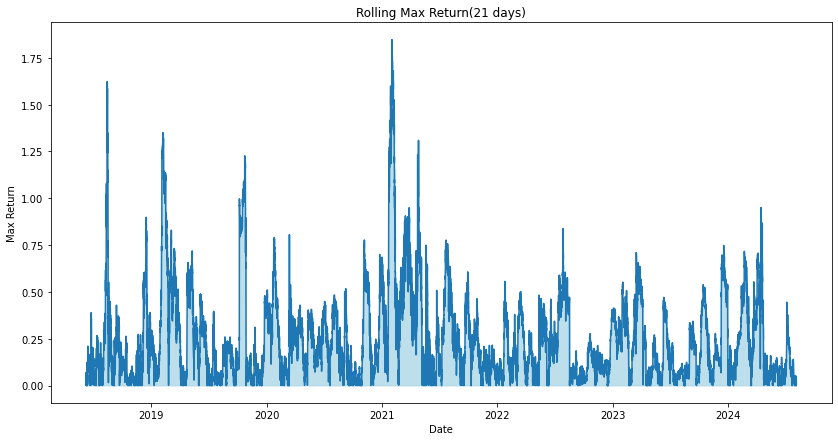

In [33]:
plt.figure(figsize=(14, 7))

plt.plot(df_max_return.index, df_max_return.values)
plt.fill_between(df_max_return.index, df_max_return.values.flatten(), color='lightblue', alpha=0.8)
plt.ylabel('Max Return')
plt.xlabel('Date')
plt.title(f'Rolling Max Return({round_days} days)')

In [34]:
df_max_return.describe()

,max_return
count,53889.000000
mean,0.243934
std,0.243577
min,0.000000
25%,0.066427
50%,0.173140
75%,0.350965
max,1.847776


결과를 요약하면 역사적으로 ONT가격이 21일동안 최대로 상승했을때 상승폭은 184.8% 이고 평균적으로 21일동안 최대 상승폭은 24.4% 가 된다. 단, 보수적으로 1시간 마다 결과를 측정하였기 때문에(실제 스테이킹은 1시간 마다 진입하는 것이 아닌 대략 21일에 한번 진입.) 위 결과는 확률적으로 청산 위험이 과대하게 평가될 수 있다.